### Solving Poisson Equation on S^2: $\Delta u = f$


In [1]:
import my_backends 
from my_backends.ducc0_wrapper import *
import my_shcoeffs
from my_shcoeffs import SHCoeffs
## my_shcoeffs contains expand_adjoint_analysis

[Errno 2] No such file or directory: '/Users/aparnagupte/Documents/cornell-reu-2021/PDPINN/doc/plmbar.doc'
[Errno 2] No such file or directory: '/Users/aparnagupte/Documents/cornell-reu-2021/PDPINN/doc/plmbar_d1.doc'
[Errno 2] No such file or directory: '/Users/aparnagupte/Documents/cornell-reu-2021/PDPINN/doc/plbar.doc'
[Errno 2] No such file or directory: '/Users/aparnagupte/Documents/cornell-reu-2021/PDPINN/doc/plbar_d1.doc'
[Errno 2] No such file or directory: '/Users/aparnagupte/Documents/cornell-reu-2021/PDPINN/doc/plmon.doc'
[Errno 2] No such file or directory: '/Users/aparnagupte/Documents/cornell-reu-2021/PDPINN/doc/plmon_d1.doc'
[Errno 2] No such file or directory: '/Users/aparnagupte/Documents/cornell-reu-2021/PDPINN/doc/plon.doc'
[Errno 2] No such file or directory: '/Users/aparnagupte/Documents/cornell-reu-2021/PDPINN/doc/plon_d1.doc'
[Errno 2] No such file or directory: '/Users/aparnagupte/Documents/cornell-reu-2021/PDPINN/doc/plmschmidt.doc'
[Errno 2] No such file or dir

In [2]:
import torch

N = 20
from Basis import SPHBasis
from Problem import Problem_Sphere_Poisson
from Model import Model
from Net import Sphere_Net, SPH_Sphere_Net
import seaborn as sns
import matplotlib.pyplot as plt
import math
from math import pi
from spherical_harmonics import *
from torch.distributions.uniform import Uniform
from numpy import arccos
import numpy as np

import pyshtools
from pyshtools.shio import shread
from pyshtools.expand import MakeGridDH
from pyshtools.expand import SHExpandDH
from pyshtools.spectralanalysis import spectrum

torch.manual_seed(0)
maxiter = 1000
problem = Problem_Sphere_Poisson()

In [3]:
N = 20
azimuth = torch.linspace(0.0001, pi, N, requires_grad=False)
polar = torch.linspace(0, 2*pi, 2*N, requires_grad=False)

azimuth, polar = torch.meshgrid(azimuth, polar)
location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
location.shape

torch.Size([800, 2])

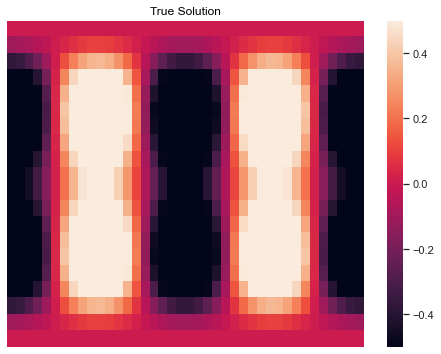

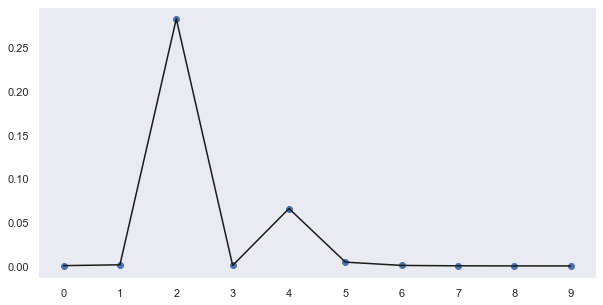

iteration 0: loss = 16712.183289122888, pde loss = 16711.873496872493


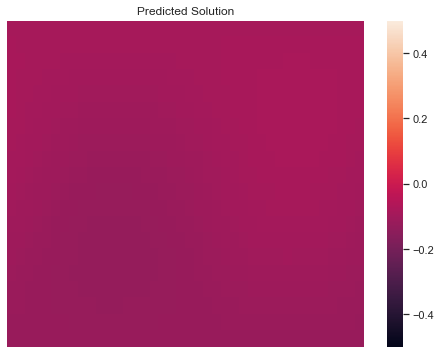

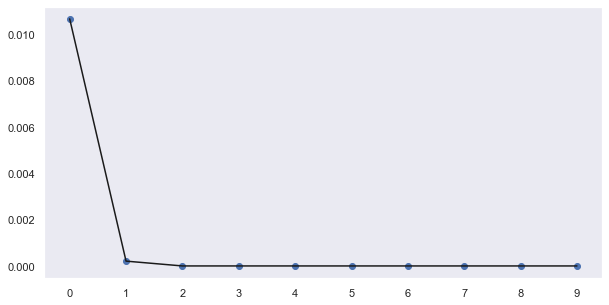

iteration 50: loss = 4638.548084020531, pde loss = 4638.533037950201
iteration 100: loss = 227.47675874099795, pde loss = 227.2377832607991
iteration 150: loss = 23.88837120079034, pde loss = 23.50506168745988
iteration 200: loss = 2.5969001986865967, pde loss = 2.3427518644218415


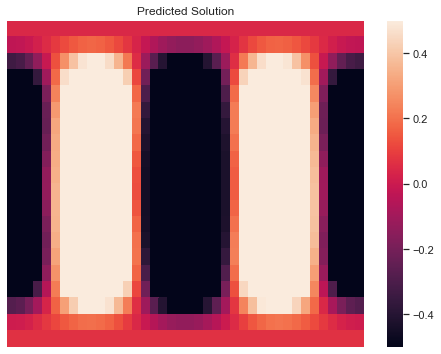

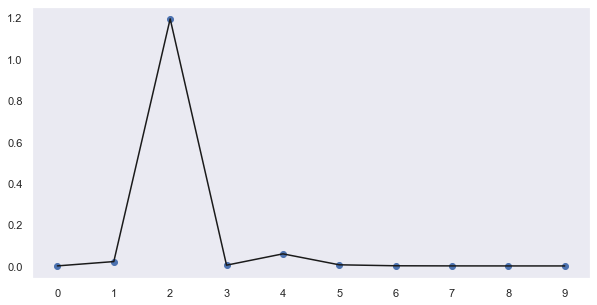

iteration 250: loss = 5.622086120923895, pde loss = 5.432179434379477
iteration 300: loss = 1.775577990916854, pde loss = 1.658551803437358
iteration 350: loss = 6.351615224834497, pde loss = 6.265640412326867
iteration 400: loss = 5.363962844489379, pde loss = 5.29503607052402


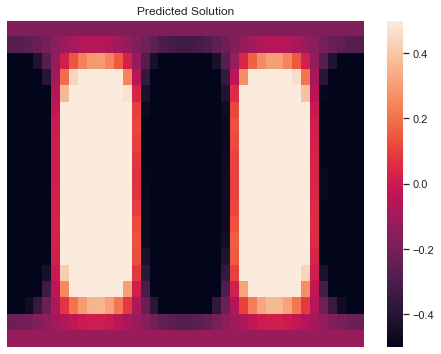

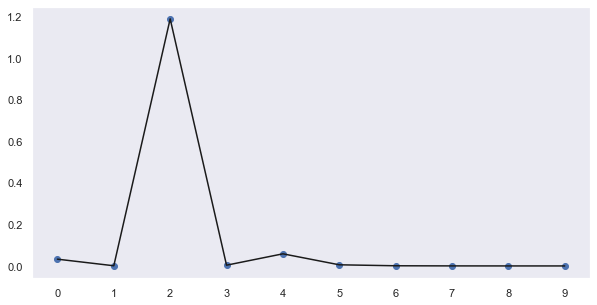

iteration 450: loss = 1.3527613174000992, pde loss = 1.30942299625075
iteration 500: loss = 0.6153820347824649, pde loss = 0.5903855548092679
iteration 550: loss = 5.930266216375242, pde loss = 5.918306872226606
iteration 600: loss = 0.11346818901317618, pde loss = 0.10077292028533719


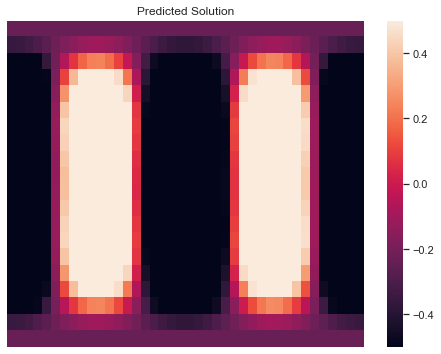

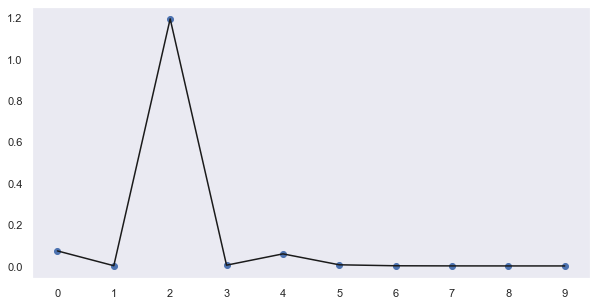

iteration 650: loss = 0.47702381402739863, pde loss = 0.46958317716160397
iteration 700: loss = 0.41949134095753704, pde loss = 0.41475519779320036
iteration 750: loss = 0.08208168846042382, pde loss = 0.07879966533230173
iteration 800: loss = 0.7133870536415988, pde loss = 0.7113045725925976


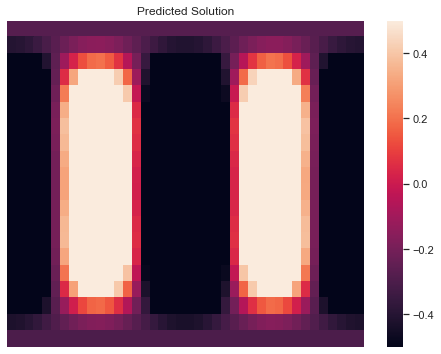

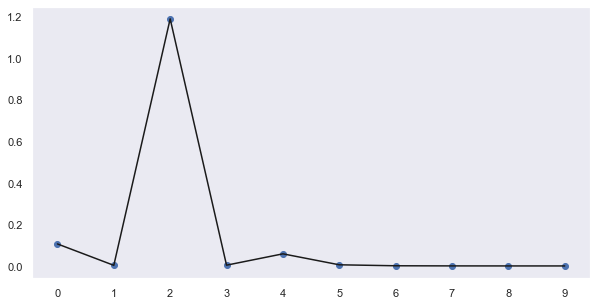

iteration 850: loss = 3.7680348415633493, pde loss = 3.767988126190176
iteration 900: loss = 0.009621559436579604, pde loss = 0.009372741884232868
iteration 950: loss = 1.5586772521217647, pde loss = 1.5586614284746467
iteration 999: loss = 7.678768798712489, pde loss = 7.6786568950300795


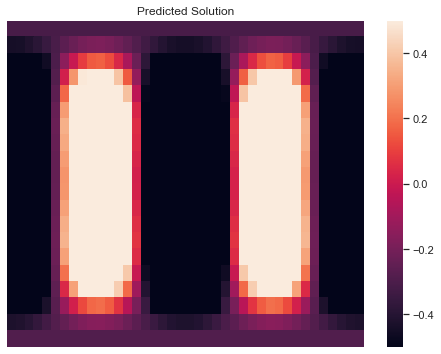

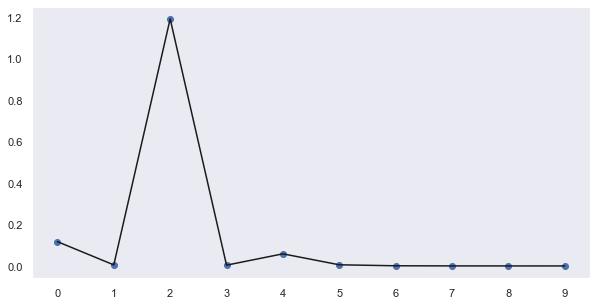

In [4]:

def construct_model(net):
    class Poisson1dModel(Model):
        def add_loss_history(self):
#             self.loss_history.append([self.bc_loss, self.pde_loss, self.predict_error_value])
            self.loss_history.append([self.pde_loss, self.predict_error_value])

        def __init__(self):
            super().__init__(problem=problem, net=net, maxiter=maxiter)

        def inner_sample(self, N=N):
            azimuth = torch.linspace(0.0001, pi, N, requires_grad=False)
            polar = torch.linspace(0, 2*pi, 2*N, requires_grad=False)
            
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            return location # numpy ndarray with shape (N, 2*N)

        def bc_sample(self):
            return torch.tensor([[1., 1.]]) # arbitrary point is okay?

        def init_sample(self):
            pass

        def plot(self, net):
            azimuth = torch.linspace(0, math.pi, N, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 2*N, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
#             location = self.inner_sample()
            value = net(location) # predicted solution
            
            value = value.reshape((N, 2*N))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Predicted Solution")
            plt.show()
            
            self.spherical_harmonic_transform(net)
        
        def spherical_harmonic_transform(self, net):
            azimuth = torch.linspace(0, math.pi, N, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 2*N, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            function_grid = net(location)
            function_grid = function_grid.reshape((N, 2*N))
            
            coefficients = SHExpandDH(function_grid.detach().numpy(), sampling=2)
            nl = coefficients.shape[1]
            ls = np.arange(nl)[:10]

            power_per_l = spectrum(coefficients)[:10]
            fig, ax = plt.subplots(1, 1, figsize=(len(ls), 5))
            ax.plot(ls, power_per_l, 'bo')
            ax.plot(ls, power_per_l, 'k-')
            plt.xticks(range(len(ls)))
            ax.grid()
            plt.show()
            
        
        def plot_true(self):
            azimuth = torch.linspace(0, math.pi, N, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 2*N, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            value = true_solution(location[:, 0:1], location[:, 1:])
            
            value = value.reshape((N, 2*N))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("True Solution")
            plt.show()
            
            self.sht_value(value)
            
        def sht_value(self, function_grid):
            function_grid = function_grid.reshape((N, 2*N))
            
            coefficients = SHExpandDH(function_grid.detach().numpy(), sampling=2)
            nl = coefficients.shape[1]
            ls = np.arange(nl)[:10]

            power_per_l = spectrum(coefficients)[:10]
            fig, ax = plt.subplots(1, 1, figsize=(len(ls), 5))
            ax.plot(ls, power_per_l, 'bo')
            ax.plot(ls, power_per_l, 'k-')
            plt.xticks(range(len(ls)))
            ax.grid()
            plt.show()
            
        def post_process(self, ax=None):
            if ax is None:
                for losses in self.loss_history:
                    for i in range(3):
                        losses[i].detach().numpy()
                plt.plot(self.loss_history)
                plt.yscale('log')
                plt.legend(('BC loss', 'pde loss', 'predict error'))
                plt.show()
            else:
                for losses in self.loss_history:
                    for i in range(3):
                        losses[i].detach().numpy()
                ax.plot(self.loss_history)
                ax.set_yscale('log')
                ax.set_ylim(1e-4, 100)
                ax.legend(('BC loss', 'pde loss', 'predict error'))

        def predict_error(self):
            coor = self.inner_sample()
            true = self.problem.ground_truth(coor)
            predict = self.net(coor)
            predict_error = self.pde_loss_f(true, predict)
            return predict_error

        def train(self, ax100=None):
            self.plot_true()
            problem = self.problem
            net = self.net
            opt = self.opt
            maxiter = self.maxiter

            for iter in range(maxiter):
                net.zero_grad()

                coor_inner = self.inner_sample().detach().requires_grad_(True)
#                 coor_inner = self.inner_sample().requires_grad_(True)
                infer_value_inner = net(coor_inner)
#                 truth_inner, predict_inner = problem.pde(coor_inner, infer_value_inner)
                predict_inner, truth_inner = problem.pde(coor_inner, infer_value_inner) 
                ## order, is the lhs even the predicted value???
                ## reason the loss function is going up could be because we are computing the negative gradient, which could happen by switching the order of y, y_pred in orward and backward functions of the loss.
        
                self.pde_loss = self.pde_loss_f(predict_inner, truth_inner)
            
                bc_samples = self.bc_sample()
                if bc_samples is None:
                    self.bc_loss = torch.tensor(0.)
                else:
                    coor_bc = bc_samples.detach().requires_grad_(True)
                    infer_value_bc = net(coor_bc)
                    truth_bc, predict_bc = problem.bound_condition(coor_bc, infer_value_bc)
                    self.bc_loss = self.bc_loss_f(predict_bc, truth_bc)

                init_samples = self.init_sample()
                if init_samples is None:
                    self.init_loss = torch.tensor(0.)
                else:
                    coor_init = init_samples.detach().requires_grad_(True)
                    infer_value_init = net(coor_init)
                    truth_init, predict_init = problem.bound_condition(coor_init, infer_value_init)
                    self.init_loss = self.bc_loss_f(predict_init, truth_init)
                    
                self.predict_error_value = self.predict_error()
                self.total_loss = self.pde_loss + self.bc_loss + self.init_loss
                self.add_loss_history()
#                 self.total_loss.register_hook(lambda grad: print('gradient', grad))
                self.total_loss.backward()

                opt.step()
                opt.zero_grad()
#                 scheduler.step()
                
                if iter % (maxiter // 20) == 0:
                    print("iteration {}: loss = {}, pde loss = {}".format(iter, self.total_loss, self.pde_loss))
                        
                if iter % int(maxiter / 5) == 0:
                    self.plot(net)
            print("iteration {}: loss = {}, pde loss = {}".format(iter, self.total_loss, self.pde_loss))    
            self.plot(net)
            
#             self.post_process()

    return Poisson1dModel()

model = construct_model(Sphere_Net([3, 150, 50, 50, 50, 16, 1]))
model.train()
